In [2]:
import pandas as pd
import numpy as np
import pickle
import os
os.chdir('/home/lichi/jupiter/imaginarium')

from random import sample
from PIL import Image
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
import keras.backend as K
from keras.layers import Conv1D,Activation, Reshape, Conv2D,Input, Dense, dot, multiply, add, concatenate, Lambda

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from visual import tools, evaluation

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def mean_squared_error_keras(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=2)
k = 10

### Делаем сетку

In [12]:
emb_dim = 100
k = 10
num_words = 998
# Вектора для k картинок
X_images_net = Input(shape=(k,1024), name = 'X_images_net')

# Вектора для k картинок 2
X_images_net3 = Input(shape=(k,1024), name = 'X_images_net3')

# Вектора для k картинок 3
X_images_net4 = Input(shape=(k,1024), name = 'X_images_net4')


# Вектор для правильной картинки, размноженной 1000 раз - по количеству слов
X_image_true_net = Input(shape=(num_words, 1024), name = 'X_image_true_net')

# Вектора для всех слов
X_text_all_net = Input(shape = (num_words, 1024), name = 'X_text_all_net')



# Вектор для того, какая картинка была авторской
y_true_image_net = Input(shape=(1,k), name = 'y_true_image_net')

conv_img_words2 = Dense(100, name = 'dense_img_words2')

conv_img_words34 = Dense(100, name = 'dense_img_words34')

# Эмбеддинги для правильной картинки (размноженной по числу слов)
image_net2 = conv_img_words2(X_image_true_net)
# Эмбединги для слов
word_net2 = conv_img_words2(X_text_all_net)

# Обрабатываем Dense слоем k картинок
image_all_net2 = conv_img_words2(X_images_net)


# Обрабатываем Dense слоем k картинок
image_all_net3 = conv_img_words34(X_images_net3)

# Обрабатываем Dense слоем k картинок
image_all_net4 = conv_img_words34(X_images_net4)

# Считаю расстояния от картинки до текста, представляю картинку как взвешенную сумму слов
distance_layer2 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,num_words), name = 'distance_layer2')([image_net2, word_net2])
weights_for_words2 = Activation('softmax',name = 'weights_for_words2')(distance_layer2)

# Меняем форму слоев, чтобы их перемножить
weights_for_words2_resh = Reshape((num_words, 1), name = 'weights_for_words2_resh')(weights_for_words2)
#word_net2_resh = Reshape((emb_dim,num_words), name = 'word_net2_resh')(word_net2)



# Перемножаем
merge_layer2 = multiply([word_net2, weights_for_words2_resh ],  name = 'merge_layer2')

# Усредняем, получаем вектор для финального слова
sum_layer2 = Lambda(lambda x: K.sum(x, axis = 1), output_shape=(1,emb_dim), name = 'sum_layer2')(merge_layer2)

# Размножаем вектор для финального слова
final_word_vector_k = Lambda(lambda x: K.repeat(x, k), output_shape=(10, emb_dim),
                             name = 'final_word_vector_k')(sum_layer2)







# Считаем расстояния от полученного вектора слов до k картинок
distance_layer_final = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k),
                              name = 'distance_layer_final')([image_all_net2, final_word_vector_k])

distance_layer_final3 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k),
                              name = 'distance_layer_final3')([image_all_net3, final_word_vector_k])
distance_layer_final4 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k),
                              name = 'distance_layer_final4')([image_all_net4, final_word_vector_k])





# Подаем в Dense
output2 = Activation('softmax', name = 'output2')(distance_layer_final)
output3 = Activation('softmax', name = 'output3')(distance_layer_final3)
output4 = Activation('softmax', name = 'output4')(distance_layer_final4)
#подбираем картинки
model_hard = Model(inputs=[X_images_net, X_images_net3, X_images_net4, X_image_true_net, X_text_all_net],
                   outputs=[output2, output3, output4])
model_hard.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#
# Бейзлайн - количество угаданных слов или лосс по фиксированным image captioning эмбеддингам

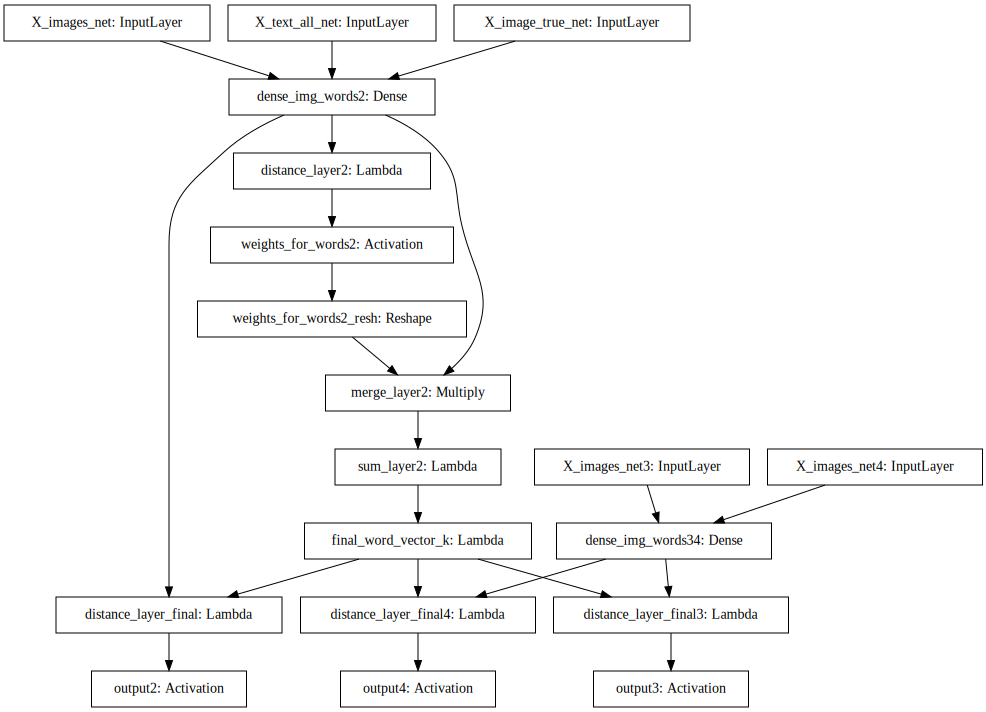

In [14]:
from keras.utils import plot_model
plot_model(model_hard, to_file='model_imadg.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_hard).create(prog='dot', format='svg' ))
